# Introduction to the time-series trend analysis using the MODIS Ocean Colour Dataset in DEA

**What does this notebook do?** 
This notebook demonstrates how to conduct and plot time-series trend analysis for a location.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

In [3]:
dc.list_products()

,name,description,instrument,product_type,time,lon,platform,creation_time,format,label,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
5,modis_oc_1d,MODIS Ocean Cover Daily,None,modis_oc_1d,None,None,MODIS,None,None,None,None,EPSG:4326,"(-0.01, 0.01)",None,"(latitude, longitude)"


**These are the available measurements**

In [4]:
dc.list_measurements()

dtype                 name  nodata  \
product     measurement                                                 
modis_oc_1d K_490                float32                K_490  -999.0   
            chl_gsm              float32              chl_gsm  -999.0   
            chl_oc3              float32              chl_oc3  -999.0   
            dt                   float32                   dt  -999.0   
            ipar                 float32                 ipar  -999.0   
            l2_flags               int32             l2_flags    -1.0   
            nanop_brewin2010at   float32   nanop_brewin2010at  -999.0   
            nanop_brewin2012in   float32   nanop_brewin2012in  -999.0   
            npp_vgpm_eppley_gsm  float32  npp_vgpm_eppley_gsm  -999.0   
            npp_vgpm_eppley_oc3  float32  npp_vgpm_eppley_oc3  -999.0   
            owtd                    int8                 owtd    -1.0   
            par                  float32                  par  -999.0   
            picop_brewin2010at   float32   picop_brewin2010at  -999.0   
            picop_brewin2012in   float32   picop_brewin2012in  -999.0   
            sst                  float32                  sst  -999.0   
            sst_quality            int16          sst_quality    -1.0   

                                                          units  
product     measurement                                          
modis_oc_1d K_490                                          m^-1  
            chl_gsm                                      mg/m^3  
            chl_oc3                                      mg/m^3  
            dt                   days since 2016-01-01 00:00:00  
            ipar                                  Ein m^-2 s^-1  
            l2_flags                                          1  
            nanop_brewin2010at                          percent  
            nanop_brewin2012in                          percent  
            npp_vgpm_eppley_gsm                    mg.m^-3.d^-1  
            npp_vgpm_eppley_oc3                    mg.m^-3.d^-1  
            owtd                                              1  
            par                                 Ein m^-2 day^-1  
            picop_brewin2010at                          percent  
            picop_brewin2012in                          percent  
            sst                                         Celsius  
            sst_quality                                       1

**Load time series of SST and CHL_GSM for a location off the QLD coast for all available time**

In [5]:
time_series = dc.load(product='modis_oc_1d', lat=-20, lon=153, measurements=['sst','chl_gsm'])

In [6]:
time_series = mask_invalid_data(time_series)

In [9]:
time_series['time'].data

array(['2002-07-04T11:59:59.999999000', '2002-07-05T11:59:59.999999000',
       '2002-07-06T11:59:59.999999000', ...,
       '2018-10-10T11:59:59.999999000', '2018-10-11T11:59:59.999999000',
       '2018-10-12T11:59:59.999999000'], dtype='datetime64[ns]')

**Plot the SST time series**

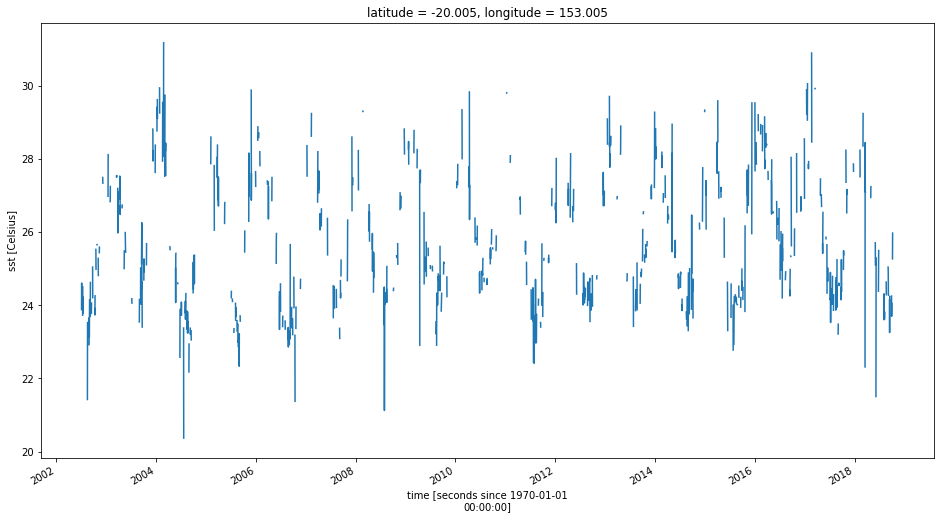

In [22]:
time_series.sst.plot(figsize=(16,8))

**Try out the interpolation features in xarray**

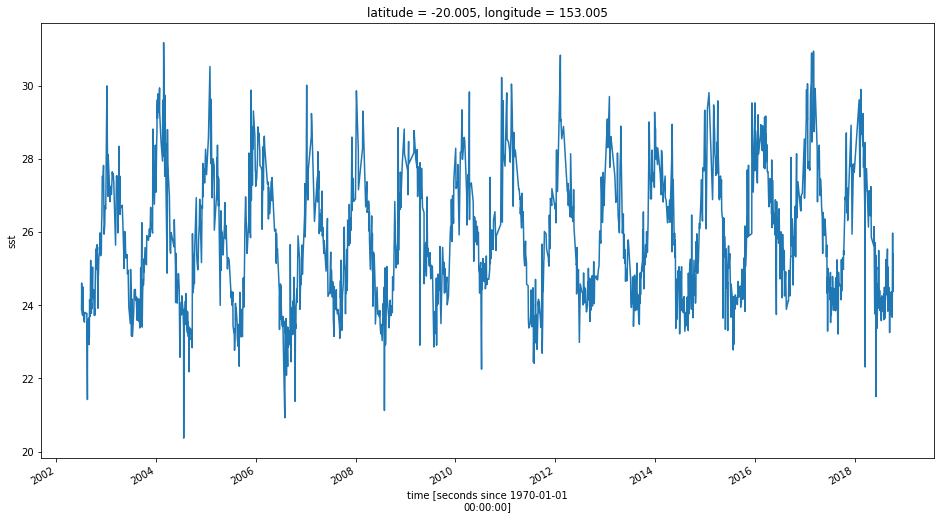

In [23]:
time_series.interpolate_na(dim='time').sst.plot(figsize=(16,8))

**Plot the CHL_GSM time series**

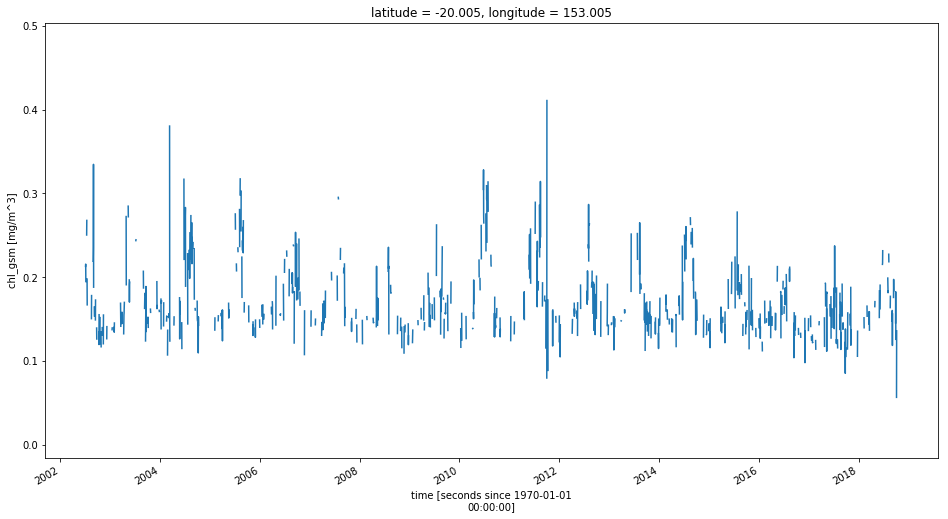

In [21]:
time_series.chl_gsm.plot(figsize=(16,8))

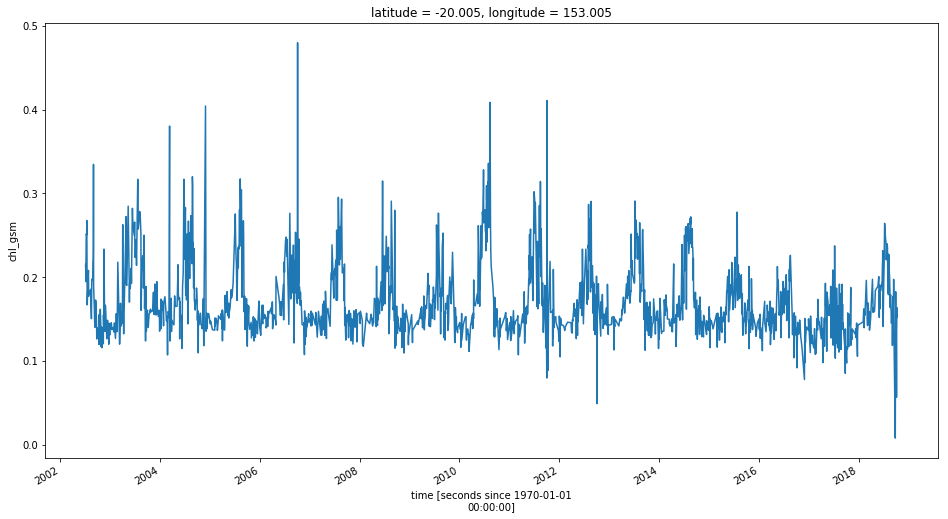

In [20]:
time_series.interpolate_na(dim='time').chl_gsm.plot(figsize=(16,8))

**obtain the interpolated SST and CHL data**

In [14]:
sst_interpolated = time_series.interpolate_na(dim='time').sst
chl_interpolated = time_series.interpolate_na(dim='time').chl_gsm

## conduct modelling fitting and trend analysis for CHL
### It appears that for this location, CHL had a decreasing trend

                            OLS Regression Results                            
Dep. Variable:                    chl   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     153.8
Date:                Wed, 16 Jan 2019   Prob (F-statistic):           6.92e-35
Time:                        17:12:38   Log-Likelihood:                 10829.
No. Observations:                5897   AIC:                        -2.165e+04
Df Residuals:                    5895   BIC:                        -2.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1795      0.001    178.542      0.0

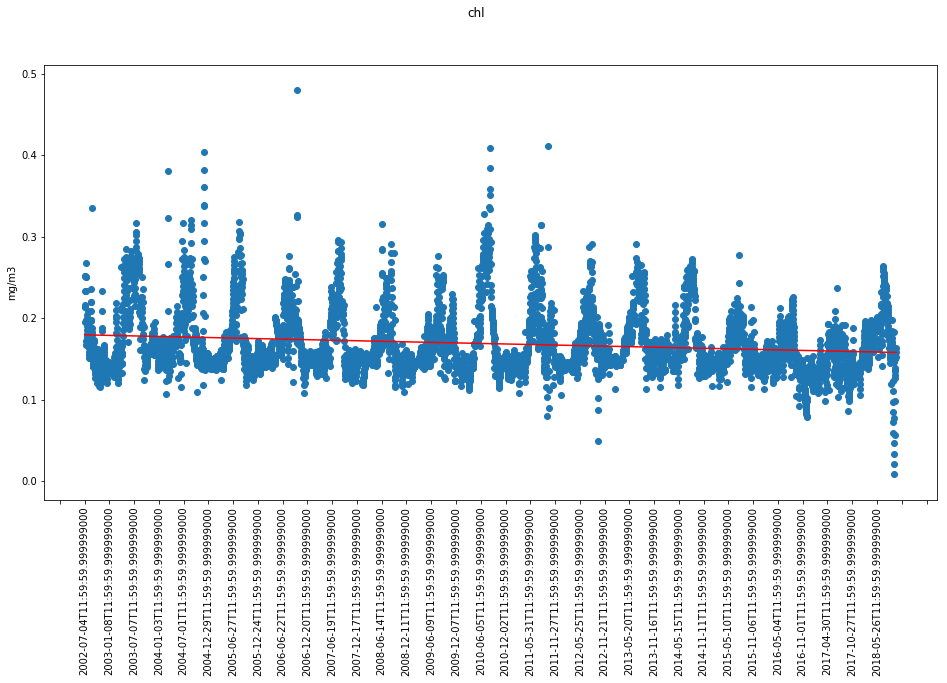

In [36]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,time_series['time'].size+1,1)
sst = np.squeeze(sst_interpolated.data)
chl = np.squeeze(chl_interpolated.data)
df = pd.DataFrame(
    ind,
    columns=['ind'])

times = np.datetime_as_string(time_series['time'].data)
df['time']=times
df['sst']=sst
df['chl']=chl
fit = sm.ols(formula='chl ~ ind', data=df).fit()
print(fit.summary())

predict = fit.predict(df)
df['fitted'] = predict

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
#x = df.index[0]
#y = df['chl'].max()
#plt.text(x,y,'R-squared = ' +"{0:.3f}".format(fit.rsquared))
ax.scatter(df.time, df.chl)
ax.xaxis.set_major_locator(ticker.MultipleLocator(180))
ax.plot(df.ind, df.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

## conduct modelling fitting and trend analysis for SST
### It appears that for this location, SST had a increasing trend (~0.6 deg in the past 16 years)

                            OLS Regression Results                            
Dep. Variable:                    sst   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     59.28
Date:                Wed, 16 Jan 2019   Prob (F-statistic):           1.60e-14
Time:                        09:12:13   Log-Likelihood:                -11628.
No. Observations:                5897   AIC:                         2.326e+04
Df Residuals:                    5895   BIC:                         2.327e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7122      0.045    567.598      0.0

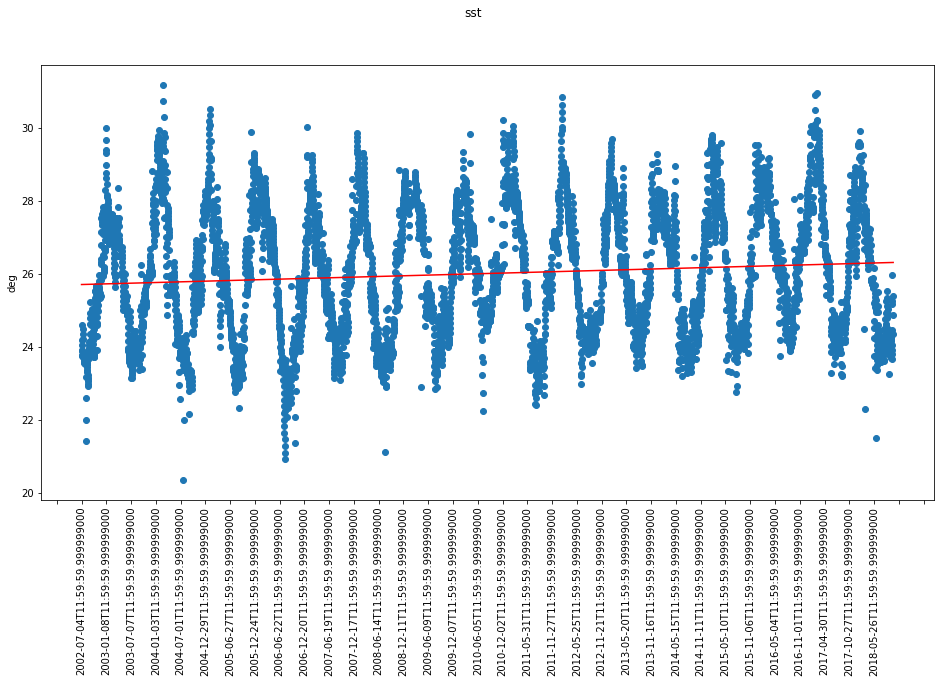

In [25]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,time_series['time'].size+1,1)
sst = np.squeeze(sst_interpolated.data)
chl = np.squeeze(chl_interpolated.data)
df = pd.DataFrame(
    ind,
    columns=['ind'])

times = np.datetime_as_string(time_series['time'].data)
df['time']=times
df['sst']=sst
df['chl']=chl
fit = sm.ols(formula='sst ~ ind', data=df).fit()
print(fit.summary())

predict = fit.predict(df)
df['fitted'] = predict

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
#x = df.index[0]
#y = df['chl'].max()
#plt.text(x,y,'R-squared = ' +"{0:.3f}".format(fit.rsquared))
ax.scatter(df.time, df.sst)
ax.xaxis.set_major_locator(ticker.MultipleLocator(180))
ax.plot(df.index, df.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('sst')

plt.show()

**calculate the daily warming rate**

In [30]:
# mean daily warming rate
(df['fitted'].max() - df['fitted'].min()) / df['fitted'].size

0.00010238320487681104

**calculate the total warming (in deg) in the entire time-series**

In [31]:
# how much warming during last 16 years
df['fitted'].max() - df['fitted'].min()

0.6040609087731852